In [13]:
#!pip install folium


# 📘 Геокластеризация

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [2]:
# Пути к данным
DATA_PATH = '../data/raw'

# Загрузка данных
orders = pd.read_csv(os.path.join(DATA_PATH, 'olist_orders_dataset.csv'))
reviews = pd.read_csv(os.path.join(DATA_PATH, 'olist_order_reviews_dataset.csv'))
items = pd.read_csv(os.path.join(DATA_PATH, 'olist_order_items_dataset.csv'))
products = pd.read_csv(os.path.join(DATA_PATH, 'olist_products_dataset.csv'))
geo = pd.read_csv(os.path.join(DATA_PATH, 'olist_geolocation_dataset.csv'))
customers = pd.read_csv(os.path.join(DATA_PATH, 'olist_customers_dataset.csv'))


# Карта с координатами покупателей

In [3]:
geo_sample = geo.dropna().sample(1000, random_state=42)
map_br = folium.Map(location=[-14.2350, -51.9253], zoom_start=4)
for _, row in geo_sample.iterrows():
    folium.CircleMarker(
        location=[row['geolocation_lat'], row['geolocation_lng']],
        radius=1,
        color='blue',
        fill=True,
        fill_opacity=0.3
    ).add_to(map_br)

# Вывод карты
map_br


# Анализ отзывов

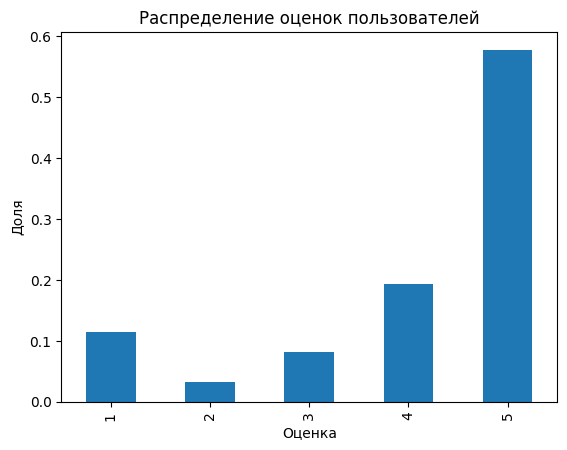

In [4]:
reviews['review_score'].value_counts(normalize=True).sort_index().plot(kind='bar')
plt.title('Распределение оценок пользователей')
plt.xlabel('Оценка')
plt.ylabel('Доля')
plt.show()



# Средняя оценка по категориям

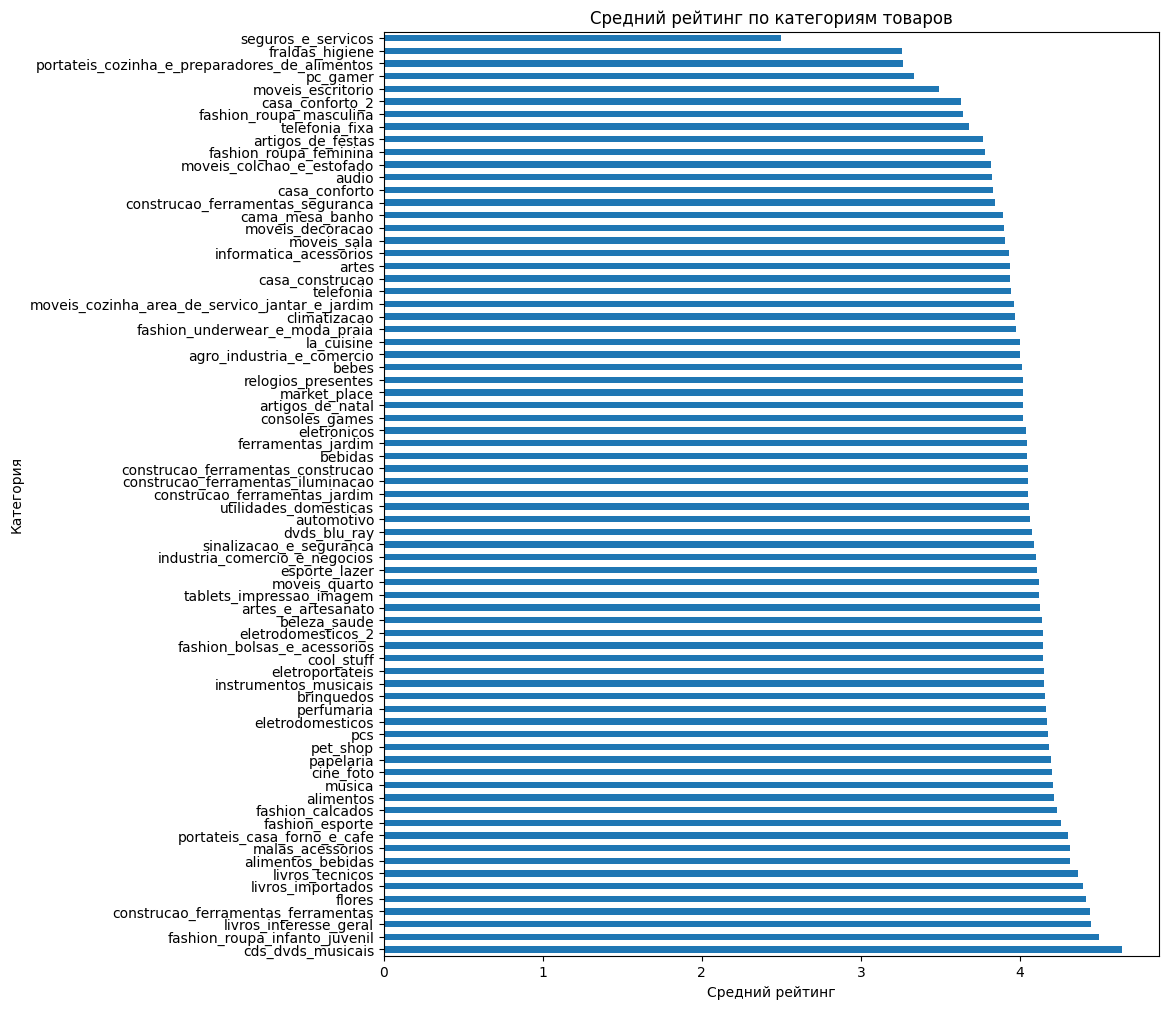

In [5]:
merged = reviews.merge(orders[['order_id', 'customer_id']], on='order_id')
merged = merged.merge(items[['order_id', 'product_id']], on='order_id')
merged = merged.merge(products[['product_id', 'product_category_name']], on='product_id')

avg_rating = merged.groupby('product_category_name')['review_score'].mean().sort_values(ascending=False)
avg_rating.plot(kind='barh', figsize=(10, 12))
plt.title('Средний рейтинг по категориям товаров')
plt.xlabel('Средний рейтинг')
plt.ylabel('Категория')
plt.show()


# Влияние времени доставки на рейтинг

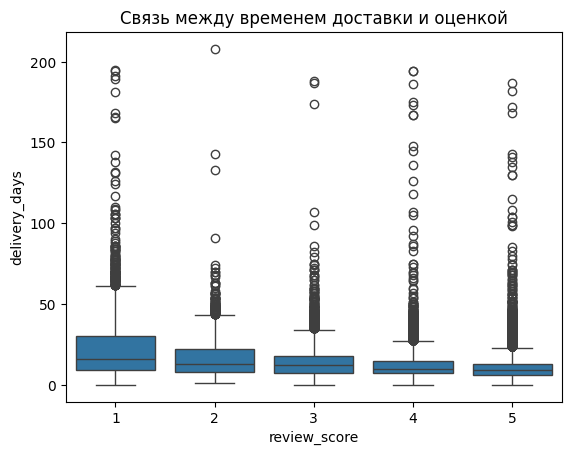

In [6]:
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['delivery_days'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).dt.days

review_delivery = reviews.merge(orders[['order_id', 'delivery_days']], on='order_id')

sns.boxplot(x='review_score', y='delivery_days', data=review_delivery)
plt.title('Связь между временем доставки и оценкой')
plt.show()


# Кластеры RFM

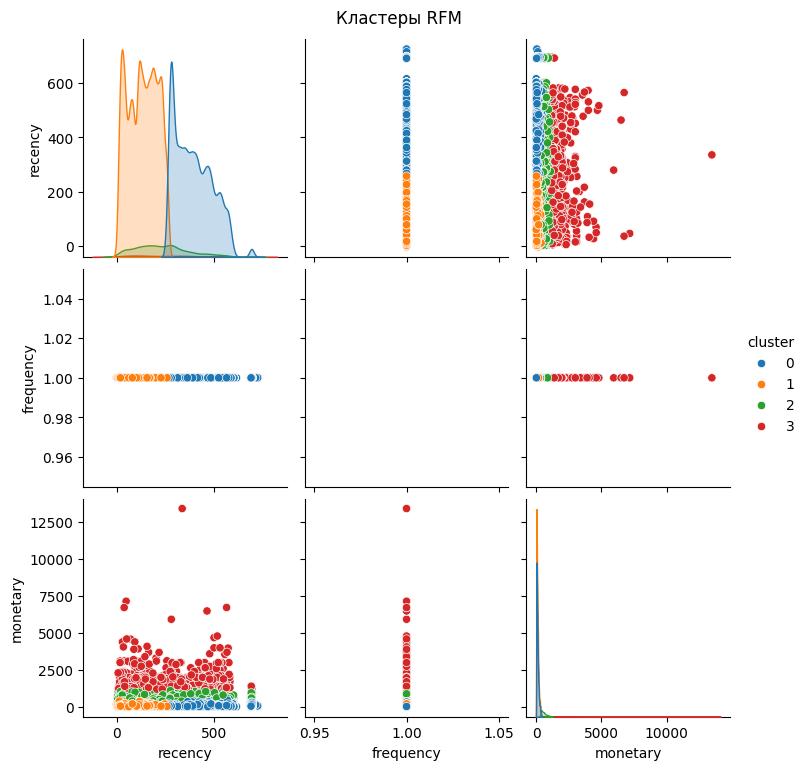

In [7]:
# Recency: разница между датой последней покупки и выбранной датой
snapshot_date = pd.to_datetime('2018-09-01')

# Последняя покупка каждого клиента
last_purchase = orders.groupby('customer_id')['order_purchase_timestamp'].max().reset_index()
last_purchase['recency'] = (snapshot_date - pd.to_datetime(last_purchase['order_purchase_timestamp'])).dt.days

# Frequency: количество заказов каждого клиента
frequency = orders.groupby('customer_id')['order_id'].count().reset_index()
frequency.columns = ['customer_id', 'frequency']

# Monetary: сумма всех покупок каждого клиента
# Сначала объединяем заказы с товарами для получения стоимости каждой покупки
orders_items = orders.merge(items, on='order_id')
monetary = orders_items.groupby('customer_id')['price'].sum().reset_index()
monetary.columns = ['customer_id', 'monetary']

# Объединяем все показатели в одну таблицу RFM
rfm = last_purchase[['customer_id', 'recency']].merge(
    frequency, on='customer_id'
).merge(
    monetary, on='customer_id'
)

# Добавляем уникальные идентификаторы клиентов 
rfm = rfm.merge(customers[['customer_id', 'customer_unique_id']], on='customer_id')

# Масштабируем данные
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['recency', 'frequency', 'monetary']])

# Кластеризация
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['cluster'] = kmeans.fit_predict(rfm_scaled)

#  Визуализация
sns.pairplot(rfm, hue='cluster', palette='tab10')
plt.suptitle('Кластеры RFM', y=1.02)
plt.show()

In [9]:
rfm.describe()

,recency,frequency,monetary,cluster
count,98666.000000,98666.0,98666.000000,98666.000000
mean,242.716072,1.0,137.754076,0.666643
std,153.392934,0.0,210.645145,0.609046
min,-3.000000,1.0,0.850000,0.000000
25%,119.000000,1.0,45.900000,0.000000
50%,224.000000,1.0,86.900000,1.000000
75%,353.000000,1.0,149.900000,1.000000
max,726.000000,1.0,13440.000000,3.000000
